## Fruits recognition

### Import all the Dependencies

In [54]:
import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt

#### Set constant

In [55]:
BATCH_SIZE = 32
IMAGE_SIZE = 300
CHANNELS=3
EPOCHS=40

#### Import fruits data into tensorflow dataset object

In [56]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 407 files belonging to 6 classes.


In [57]:
class_names = dataset.class_names
class_names

['College - Dome Building',
 'College - Old Mess StairCase',
 'College - Subway',
 'b5 - badminton court',
 'b6 - backyard',
 'b6 - ground']

In [58]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 300, 300, 3)
[0 1 5 2 4 1 4 1 5 2 2 1 4 2 4 3 2 2 3 2 2 2 2 3 0 2 0 1 2 2 1 2]


Each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

### Visualize some of the images from our dataset

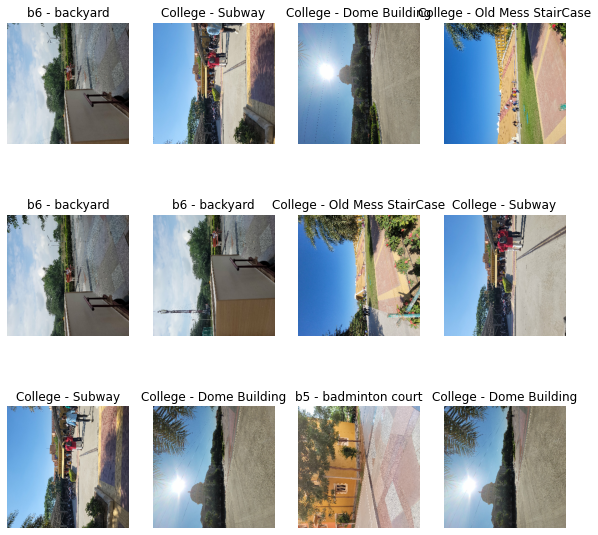

In [59]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:
<br>
**Training**: Dataset to be used while training <br>
**Validation**: Dataset to be tested against while training<br>
**Test**: Dataset to be tested against after we trained a model<br>

In [60]:
def get_dataset_partitions_tf(ds, train_split=0.5, val_split=0.25, test_split=0.25, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [61]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [62]:
len(train_ds)

6

In [63]:
len(val_ds)

3

In [64]:
len(test_ds)

4

### Cache, Shuffle, and Prefetch the Dataset

In [65]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building the Model

#### Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [66]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

#### Data Augmentation


Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.
It rorate the image in posssible way and that are used for model training.

In [67]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [68]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [69]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [70]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 300, 300, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 298, 298, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 149, 149, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 147, 147, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 73, 73, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 71, 71, 64)         

#### Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [71]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [72]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
6/6 [==============================] - 53s 7s/step - loss: 1.7484 - accuracy: 0.3115 - val_loss: 1.7325 - val_accuracy: 0.2396
Epoch 2/15
6/6 [==============================] - 20s 3s/step - loss: 1.6883 - accuracy: 0.3115 - val_loss: 1.7524 - val_accuracy: 0.2396
Epoch 3/15
6/6 [==============================] - 19s 3s/step - loss: 1.5725 - accuracy: 0.3115 - val_loss: 2.1407 - val_accuracy: 0.2396
Epoch 4/15
6/6 [==============================] - 19s 3s/step - loss: 1.4413 - accuracy: 0.3279 - val_loss: 1.8459 - val_accuracy: 0.3438
Epoch 5/15
6/6 [==============================] - 18s 3s/step - loss: 1.2140 - accuracy: 0.4918 - val_loss: 2.1104 - val_accuracy: 0.4479
Epoch 6/15
6/6 [==============================] - 18s 3s/step - loss: 0.8299 - accuracy: 0.7049 - val_loss: 3.5034 - val_accuracy: 0.4479
Epoch 7/15
6/6 [==============================] - 19s 3s/step - loss: 0.5835 - accuracy: 0.7322 - val_loss: 3.9839 - val_accuracy: 0.5000
Epoch 8/15
6/6 [==================

In [73]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 13s 588ms/step - loss: 1.4203 - accuracy: 0.6555


You can see above that we get 88.00% accuracy for our test dataset. This is considered to be a pretty good accuracy

In [74]:
scores

[1.4203022718429565, 0.6554622054100037]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [75]:
history

In [76]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 6}

In [77]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [78]:
type(history.history['loss'])

list

In [79]:
len(history.history['loss'])

15

In [80]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.7483766078948975,
 1.6883034706115723,
 1.5724676847457886,
 1.441267967224121,
 1.2140222787857056]

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

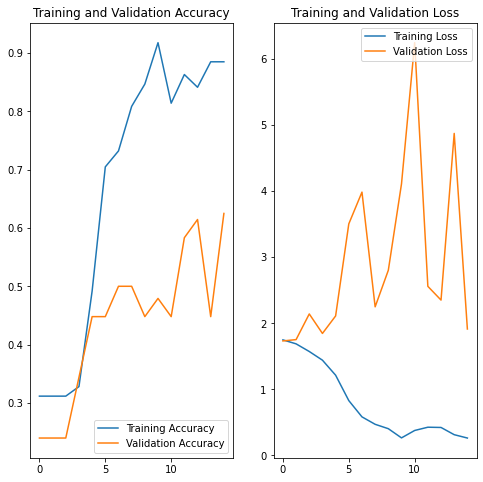

In [85]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(15), acc, label='Training Accuracy')
plt.plot(range(15), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(15), loss, label='Training Loss')
plt.plot(range(15), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Run prediction on a sample image

first image to predict
actual label: College - Old Mess StairCase
1/1 [==============================] - 1s 1s/step
predicted label: College - Old Mess StairCase


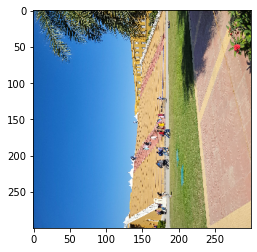

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

#### Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample imagesNow run inference on few sample images

1/1 [==============================] - 0s 60ms/step


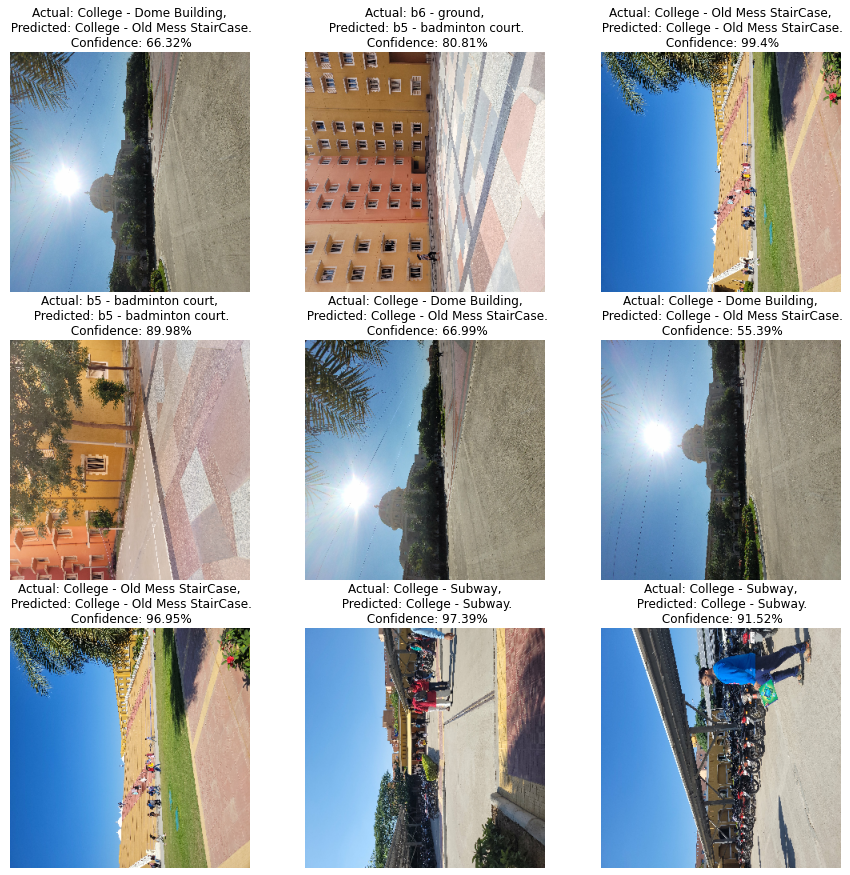

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

#### Saving the Model

We append the model to the list of models as a new version

In [ ]:
model.save("models/college.h5")